In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **18.01.2023** with version **YOLOv8.0.9**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/107.7 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://v8docs.ultralytics.com/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [ ]:
# %cd {HOME}
# Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

## Custom Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CV_Project

/content/drive/MyDrive/CV_Project


In [ ]:
#For converting labels to YOLO Format
from pathlib import Path
from PIL import Image
from multiprocessing import Pool
from tqdm import tqdm

def convert_box(size, box):
    # Convert VisDrone box to YOLO xywh box
    dw =  1. / size[0]
    dh =  1. / size[1]
    return (box[0] + box[2] /  2) * dw, (box[1] + box[3] /  2) * dh, box[2] * dw, box[3] * dh

def visdrone2yolo_worker(file_path):
    # Construct the path to the corresponding image file
    img_path = Path('/content/drive/MyDrive/CV_Project/data/test/images') / file_path.name.replace('.txt', '.jpg')
    img_size = Image.open(img_path).size
    lines = []

    with open(file_path, 'r') as file:  # read annotation.txt
        for row in [x.split(',') for x in file.read().strip().splitlines()]:
            if row[4] == '0':  # VisDrone 'ignored regions' class  0
                continue
            cls = int(row[5]) -  1
            box = convert_box(img_size, tuple(map(int, row[:4])))
            lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")

    output_path = file_path.with_name(file_path.stem + '.txt')
    with open(output_path, 'w') as fl:
        fl.writelines(lines)  # write label.txt

def visdrone2yolo(directory):
    annotation_files = list(directory.glob('*.txt'))
    with Pool() as p:  # create a pool of worker processes
        p.map(visdrone2yolo_worker, annotation_files)  # apply visdrone2yolo_worker to each file in parallel

# Set the directory where your VisDrone annotations are stored
visdrone_annotation_dir = Path('/content/drive/MyDrive/CV_Project/data/test/labels')
visdrone2yolo(visdrone_annotation_dir)  # convert VisDrone annotations to YOLO labels


In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:1024'

In [ ]:
import torch
torch.cuda.empty_cache()
%cd /content/drive/MyDrive/CV_Project
!yolo task=detect mode=train model=yolov8s.pt data= /content/drive/MyDrive/CV_Project/Visdrone.yaml epochs=25 imgsz=640 plots=True

/content/drive/MyDrive/CV_Project
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/drive/MyDrive/CV_Project/Visdrone.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dy

In [ ]:
!ls runs/detect/train12/

args.yaml					    results.csv       train_batch1.jpg	weights
events.out.tfevents.1707837413.e06c11c4c203.9203.0  train_batch0.jpg  train_batch2.jpg


In [ ]:
# Image(filename='runs/detect/train12/confusion_matrix.png', width=600)

In [ ]:
# Image(filename='runs/detect/train12/results.png', width=600)

In [ ]:
# Image(filename='runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
!yolo task=detect mode=val model=runs/detect/train12/weights/best.pt data=/content/drive/MyDrive/CV_Project/Visdrone.yaml

2024-02-13 16:50:22.986822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 16:50:22.986929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 16:50:22.992309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 16:50:25.874086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Model summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /content/drive/MyDrive/CV_Project/data/val/labels.cache... 548 images, 0 background

## Inference with Custom Model

In [ ]:
!yolo task=detect mode=predict model=runs/detect/train12/weights/best.pt conf=0.25 source=data/test/images save=True

2024-02-13 17:54:07.225837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 17:54:07.225950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 17:54:07.227529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 17:54:08.621761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Model summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs
image 1/1610 /content/drive/MyDrive/CV_Project/data/test/images/0000006_00159_d_0000001.jpg: 384x

**NOTE:** Let's take a look at few results.

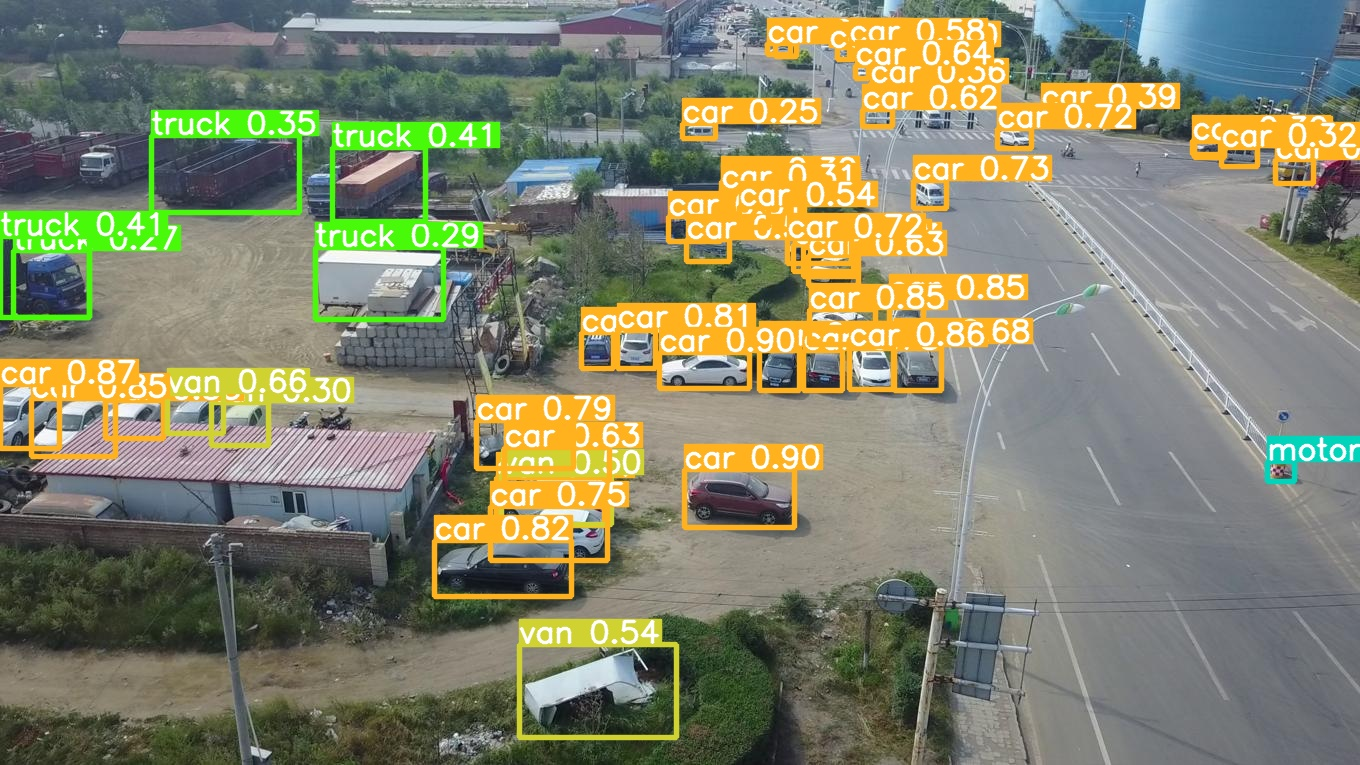

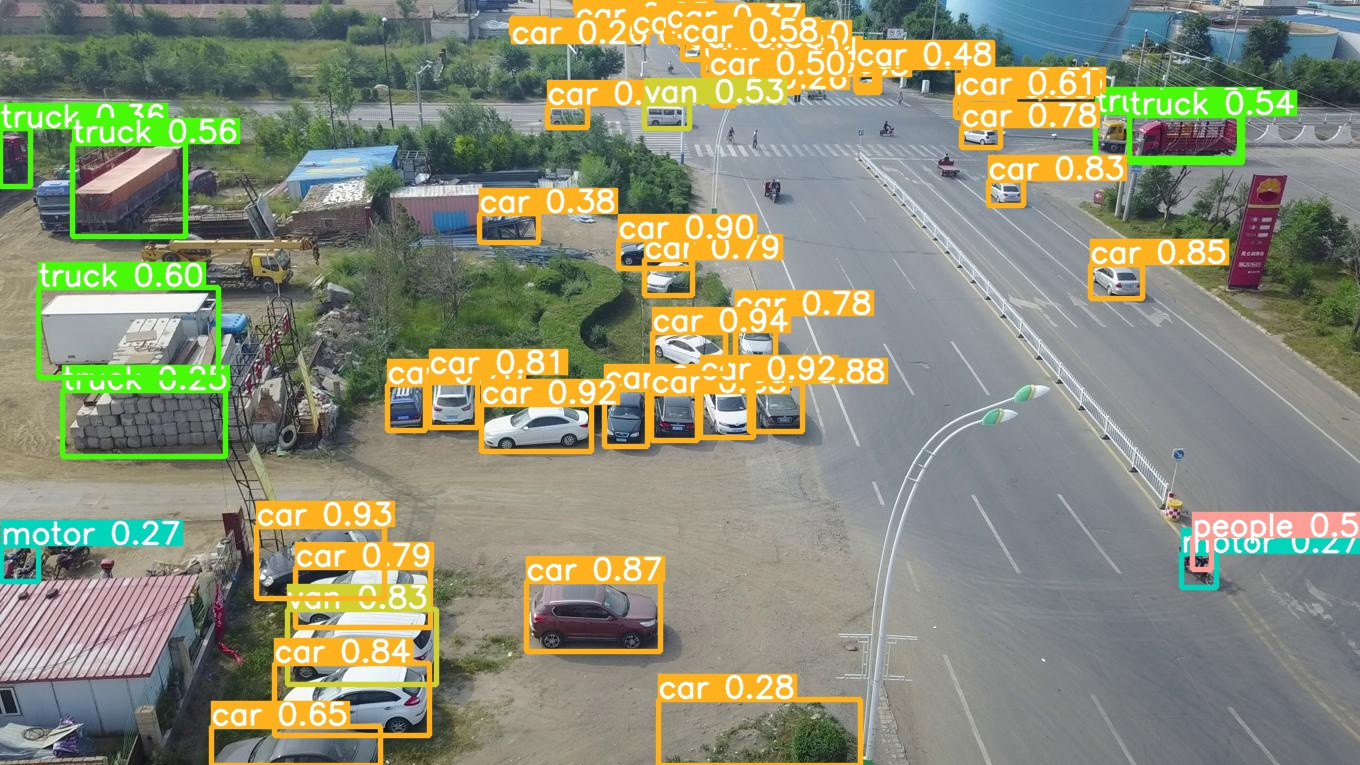

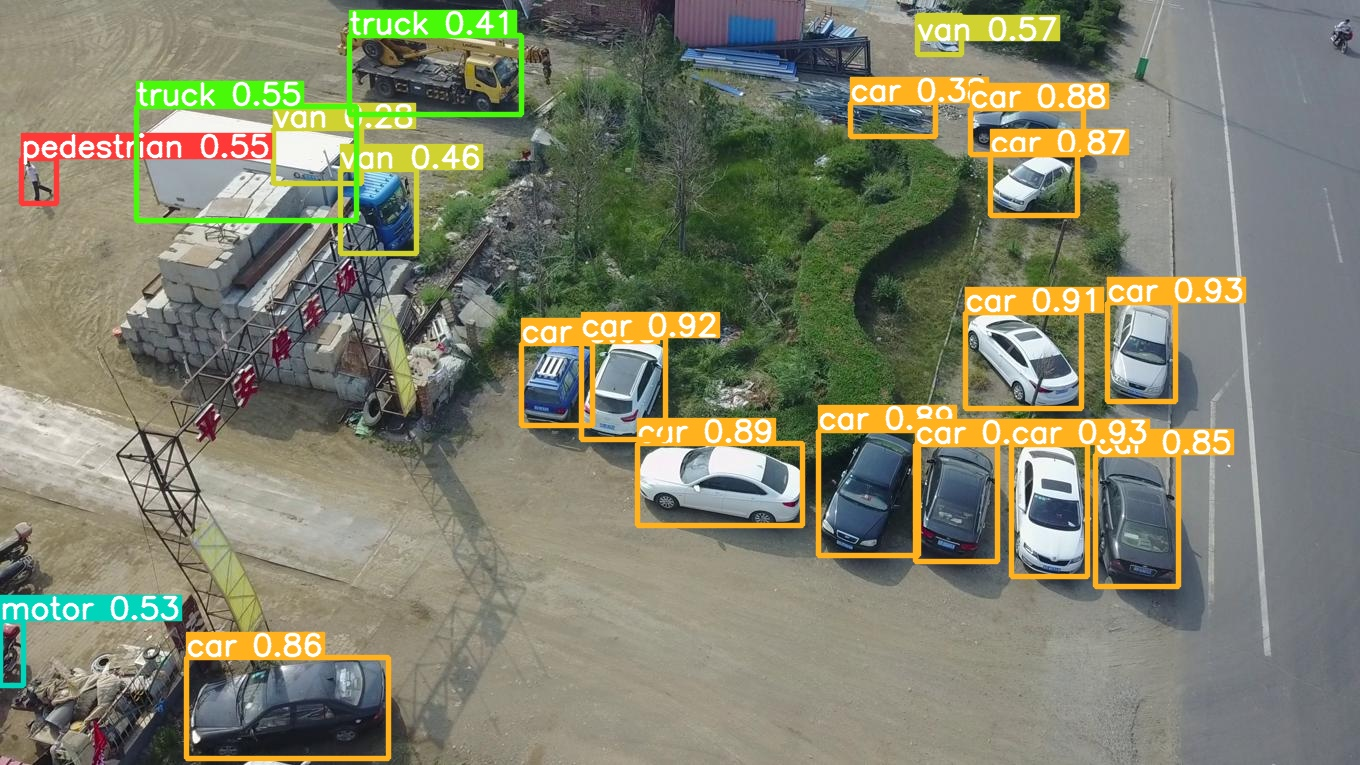

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [ ]:
# import cv2

# def annotate_image(image_path, annotation_file, output_image_path):
#     # Read the image
#     image = cv2.imread(image_path)

#     # Open the annotation file and read annotations
#     with open(annotation_file, 'r') as f:
#         annotations = f.readlines()

#     # Iterate through each annotation
#     for annotation in annotations:
#         # Split annotation into components
#         class_id, x_center, y_center, width, height = map(float, annotation.split())

#         # Convert relative coordinates to absolute coordinates
#         img_height, img_width, _ = image.shape
#         x_center_abs = int(x_center * img_width)
#         y_center_abs = int(y_center * img_height)
#         box_width = int(width * img_width)
#         box_height = int(height * img_height)

#         # Calculate box coordinates
#         x1 = int(x_center_abs - box_width / 2)
#         y1 = int(y_center_abs - box_height / 2)
#         x2 = int(x_center_abs + box_width / 2)
#         y2 = int(y_center_abs + box_height / 2)

#         # Draw bounding box on the image
#         cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

#     # Save annotated image
#     cv2.imwrite(output_image_path, image)

# # Example usage
# image_path = '/content/drive/MyDrive/CV_Project/data/test/images/0000006_00159_d_0000001.jpg'
# annotation_file = '/content/drive/MyDrive/CV_Project/data/test/labels/0000006_00159_d_0000001.txt'
# output_image_path = '/content/drive/MyDrive/CV_Project/runs/detect/output_image.jpg'

# annotate_image(image_path, annotation_file, output_image_path)


In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow
# import matplotlib.pyplot as plt

# # Dictionary mapping class indices to names
# classes = {
#     0: 'pedestrian',
#     1: 'people',
#     2: 'bicycle',
#     3: 'car',
#     4: 'van',
#     5: 'truck',
#     6: 'tricycle',
#     7: 'awning-tricycle',
#     8: 'bus',
#     9: 'motor'
# }

# # Function to read annotations from the text file
# def read_annotations(file_path):
#     annotations = []
#     with open(file_path, 'r') as file:
#         lines = file.readlines()
#         for line in lines:
#             line = line.strip().split()
#             annotations.append({
#                 'class': int(line[0]),  # Assuming class is an integer
#                 'x_center': float(line[1]),
#                 'y_center': float(line[2]),
#                 'width': float(line[3]),
#                 'height': float(line[4])
#             })
#     return annotations

# # Function to annotate the image
# def annotate_image(image_path, annotations, output_path='output.jpg'):
#     image = cv2.imread(image_path)
#     height, width, _ = image.shape

#     for ann in annotations:
#         x_center = int(ann['x_center'] * width)
#         y_center = int(ann['y_center'] * height)
#         half_width = int(ann['width'] * width /  2)
#         half_height = int(ann['height'] * height /  2)

#         # Drawing a rectangle around the annotated region
#         cv2.rectangle(image, (x_center - half_width, y_center - half_height),
#                       (x_center + half_width, y_center + half_height), (0,  255,  0),  2)

#         # Getting the class name from the dictionary
#         class_name = classes[ann['class']]

#         # Adding label text with the class name
#         label = f"{class_name}"
#         cv2.putText(image, label, (x_center - half_width, y_center - half_height -  10),
#                     cv2.FONT_HERSHEY_SIMPLEX,  0.9, (0,  255,  0),  2)
#     cv2.imwrite(output_path, image)

#     # Display the annotated image
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

# # Example usage
# annotations = read_annotations('/content/drive/MyDrive/CV_Project/data/test/labels/0000006_00159_d_0000001.txt')  # Path to your annotations text file
# annotate_image('/content/drive/MyDrive/CV_Project/data/test/images/0000006_00159_d_0000001.jpg', annotations,'/content/drive/MyDrive/CV_Project/runs/detect/output1_image.jpg')  # Path to your image file
